In [19]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras.models import Model
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from keras.optimizers import Adam
from keras.metrics import Precision, Recall, Accuracy, F1Score
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras import backend as K

In [20]:
train_path = "MacacosDataset/MacacosDataset-20231108T211111Z-001/MacacosDataset/training"
val_path = "MacacosDataset/MacacosDataset-20231108T211111Z-001/MacacosDataset/validation"
test_path = "MacacosDataset/MacacosDataset-20231108T211111Z-001/MacacosDataset/test"

batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255.
)

test_datagen = ImageDataGenerator(
    rescale = 1./255.
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224, 224),
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    val_path,
    target_size = (224, 224),
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = (224, 224),
    batch_size = batch_size,
    class_mode = "categorical"
)

train_num = train_generator.samples
validation_num = validation_generator.samples

for image, label in train_generator:
    print(image.shape)
    print(label.shape)
    break

Found 1098 images belonging to 10 classes.
Found 252 images belonging to 10 classes.
Found 30 images belonging to 10 classes.
(32, 224, 224, 3)
(32, 10)


In [43]:
base = ResNet50(weights = 'imagenet',
                pooling = "avg",
                include_top = False,
                input_shape = (224, 224, 3),
                classes = 10
                )
#base = Model(inputs=base.input, outputs=base.layers[-2].output)

for layer in base.layers:
    layer.trainable = False

model_resnet50 = Sequential()
model_resnet50.add(base)
model_resnet50.add(Flatten())
model_resnet50.add(Dense(512, activation = "relu"))
model_resnet50.add(Dense(10, activation = "softmax"))

model_resnet50.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_10 (Flatten)        (None, 2048)              0         
                                                                 
 dense_20 (Dense)            (None, 512)               1049088   
                                                                 
 dense_21 (Dense)            (None, 10)                5130      
                                                                 
Total params: 24641930 (94.00 MB)
Trainable params: 1054218 (4.02 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [44]:
model_resnet50.compile(
    loss = CategoricalCrossentropy(),
    optimizer = Adam(),
    metrics = ['accuracy']
)

In [45]:
epochs = 20

filepath = ("Weights/resnet50weights.h5")

callbacks_list = [
    ModelCheckpoint(
        filepath,
        monitor = "val_accuracy",
        verbose = 1,
        save_best_only = True,
        mode = 'max'
    )
]

history = model_resnet50.fit(
    train_generator,
    steps_per_epoch=train_num//batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_num//batch_size,
    callbacks = callbacks_list
)

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 2.4297 - accuracy: 0.1276
Epoch 1: val_accuracy improved from -inf to 0.15179, saving model to Weights\resnet50_weights.h5
34/34 [==============================] - 90s 3s/step - loss: 2.4297 - accuracy: 0.1276 - val_loss: 2.3351 - val_accuracy: 0.1518
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 2.2604 - accuracy: 0.1567
Epoch 2: val_accuracy improved from 0.15179 to 0.16518, saving model to Weights\resnet50_weights.h5
34/34 [==============================] - 84s 2s/step - loss: 2.2604 - accuracy: 0.1567 - val_loss: 2.2420 - val_accuracy: 0.1652
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 2.1991 - accuracy: 0.1717
Epoch 3: val_accuracy improved from 0.16518 to 0.20982, saving model to Weights\resnet50_weights.h5
34/34 [==============================] - 83s 2s/step - loss: 2.1991 - accuracy: 0.1717 - val_loss: 2.1789 - val_accuracy: 0.2098
Epoch 4/20
34/34 [================

<Figure size 640x480 with 0 Axes>

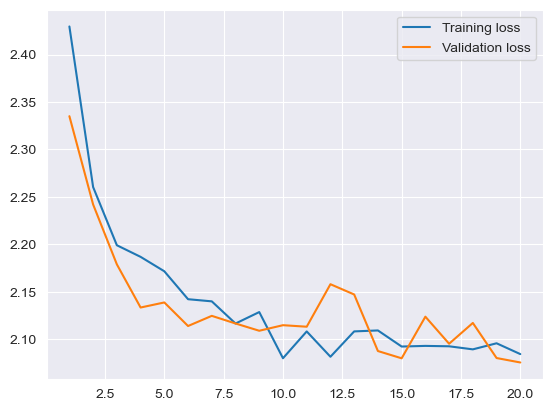

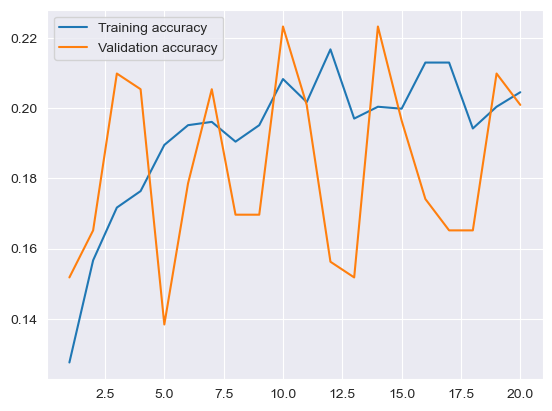

<Figure size 640x480 with 0 Axes>

In [46]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label = "Training loss")
plt.plot(epochs, val_loss, label = "Validation loss")
plt.legend()
plt.figure()

plt.plot(epochs, acc, label = "Training accuracy")
plt.plot(epochs, val_acc, label = "Validation accuracy")
plt.legend()
plt.figure()

In [49]:
import seaborn as sns
from keras.models import load_model

1/1 [==============================] - 2s 2s/step


<Axes: >

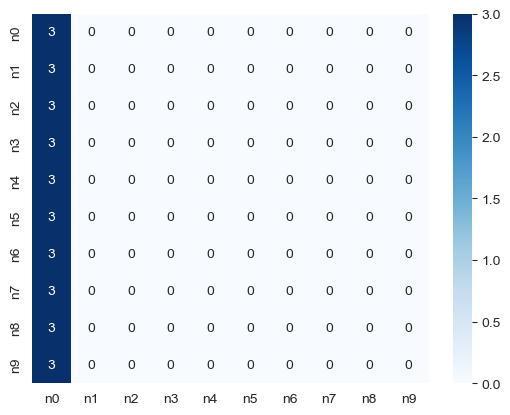

In [57]:
from sklearn.utils.fixes import sklearn
from sklearn.metrics import confusion_matrix
threshold = 0.5
#model_resnet50 = load_model("Weights/resnet50weights.h5")
y_pred = (model_resnet50.predict(test_generator)>= threshold).astype(int)

y_pred = y_pred.argmax(axis=1)
y_real = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9])



confusion_matrix = sklearn.metrics.confusion_matrix(y_real, y_pred)
labels =["n0", "n1", "n2", "n3", "n4", "n5", "n6", "n7", "n8", "n9"]
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, )